In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Класи Imagenette
class_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church',
               'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

# Підготовка та аугментація
def preprocess_data(example):
    image, label = example["image"], example["label"]
    image = tf.image.resize(image, (227, 227))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def prepare_dataset(dataset, augment=False, batch_size=32):
    dataset = dataset.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Завантаження датасету
(train_ds, val_ds, test_ds), info = tfds.load(
    'imagenette/160px',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    with_info=True
)

train_dataset = prepare_dataset(train_ds, augment=True)
val_dataset = prepare_dataset(val_ds)
test_dataset = prepare_dataset(test_ds)

# Модель AlexNet
def create_alexnet(input_shape, num_classes):
    model = Sequential([
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Створення та тренування моделі
input_shape = (227, 227, 3)
num_classes = len(class_names)

model = create_alexnet(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
model.fit(train_dataset, validation_data=val_dataset, epochs=30)

# Оцінка
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Accuracy:", test_acc)

# Збереження моделі
model.save("alexnet_imagenette.h5")

# --- PREDICTION ФУНКЦІЯ ---
def predict_image(image_path, model, class_names):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((227, 227))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,323,722 (222.49 MB)

 Trainable params: 58,323,018 (222.48 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 117s 353ms/step - accuracy: 0.2916 - loss: 2.0870 - val_accuracy: 0.1556 - val_loss: 2.5932
Epoch 2/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 131s 325ms/step - accuracy: 0.5031 - loss: 1.4992 - val_accuracy: 0.4809 - val_loss: 1.5445
Epoch 3/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 102s 328ms/step - accuracy: 0.5776 - loss: 1.2770 - val_accuracy: 0.5290 - val_loss: 1.3984
Epoch 4/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 103s 333ms/step - accuracy: 0.6134 - loss: 1.1766 - val_accuracy: 0.6153 - val_loss: 1.1509
Epoch 5/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 141s 328ms/step - accuracy: 0.6286 - loss: 1.1052 - val_accuracy: 0.6551 - val_loss: 1.0540
Epoch 6/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 143s 331ms/step - accuracy: 0.6633 - loss: 1.0036 - val_accuracy: 0.6536 - val_loss: 1.0704
Epoch 7/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 102s 325ms/step - accuracy: 0.7029 - loss: 0.9110 - val_accuracy: 0.5522 - val_loss: 1.4510
Epoch 8/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 104s 333ms/step - accuracy: 0.7095 -

Test Accuracy: 0.7026887536048889


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


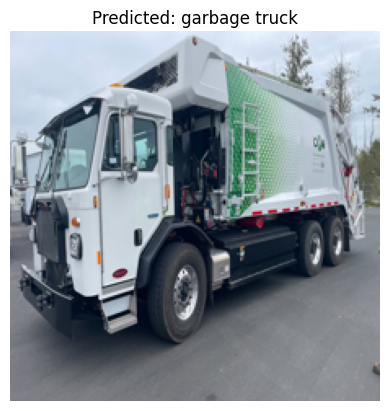

Predicted class: garbage truck


In [ ]:
# Після тренування або завантаження моделі
model = tf.keras.models.load_model("alexnet_imagenette.h5")

# Шлях до свого зображення
image_path = "garbage_truck_test.jpg"
predicted_class = predict_image(image_path, model, class_names)
print("Predicted class:", predicted_class)